# Bus Parameter Validation

In this notebook we validate the electric bus parameters we'll input to FASTSim. This must be done before we can trust our FASTSim CDMX bus route simulation outputs.

We don't have a lot of great options to validate our simulation output against experimental results, so we'll compare our simulation results to the simulation results from the 2021 LOGIOS study of electrifying bus routes in Mexicali.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
from fastsim import simdrive, vehicle, cycle
import utils
utils.run_tests()

## The hybrid Yutong/Logios Bus Parameters

The bus parameters used in these simulations were arrived at as follows:

1. Initial values: Copied from Gabriel's work to approximate the Yuton E12 bus.
1. Updated based on the LOGIOS report, To approximate the buses they used when recording their drive cycles), using the values in table 1 of *Deliverable 4*.
    1. See the *Exploring LOGIOS' Discriminated Consumption vs Energy Available Graphs* section of this notebook to explain why we set auxKw to 0.
    1. minSoc and maxSoc were set to 0% and 100% respectively to mimic the logios *Energy Available* graphs (e.g. Fig 4 of *Deliverable 4*)

Below we output a summary parameters that were updated from the Yutong parameters:

In [3]:
# Highlight the parameter differences between the yutong bus parameters and the newer 
# parameters we're using to approximate the buses used by LOGIOS in their report.
vehicles_df = pd.read_csv(Path('./bus.csv'))
yutong = vehicles_df.iloc[0]
logios = vehicles_df.iloc[1]
diff_cols = []
for i in range(len(yutong)):
    if (yutong[i] != logios[i]) and not pd.isnull(yutong[i]):
        diff_cols.append(yutong.index[i])
vehicles_df.filter(diff_cols)

,Selection,Scenario name,frontalAreaM2,gliderKg,cargoKg,maxMotorKw,maxEssKwh,minSoc,maxSoc,auxKw
0,1,Yutong,7.46,10000,5000,350,295,10%,90%,10
1,2,LOGIOS/Yutong,8.50,14050,3600,300,325,0%,100%,0


## The LOGIOS drive cycles

We'll use FASTSim to simulate the power requirements of multiple LOGIOS-recorded drive cycles. 

In [4]:
bus = vehicle.Vehicle(2, veh_file=Path('./bus.csv'))
bus_jit = bus.get_numba_veh()

In [5]:
INPUT_PATH = '../Data/LOGIOS Data/Drive Cycles'
routes_and_days = {
    'AB03': {
        # Days when drive cycle data was collected for this route
        'days': ['0520', '0521', '0527', '0531'],
        
        # LOGIOS-predicted range along this route from 100% to 0% SOC.
        # Extracted from LOGIOS 'Energy Available' graph in deliverable 4 report. e.g. Fig. 4.
        'rangeKm': 221.18,
    },
    'TC08': {
        'days': ['0525'], 
        'rangeKm': 245.32,
    },
    'ATE09': {
        'days': ['0520', '0521', '0525', '0527'],
        'rangeKm': 227.11
    }
}

# Simulate all distinct (route,day) drive cycles and store results
results = {}
for route_name in routes_and_days.keys():
    route = routes_and_days[route_name]
    for day in route['days']:
        print(f'Processing route {route_name}, day {day}...')
        drive_cycle_path = Path(INPUT_PATH) / route_name / day
        output = utils.run_fastsim(drive_cycle_path, bus_jit)
        output['fastsim_range'] = output['rangeKm']
        output['logios_range'] = route['rangeKm']
        results[f'{route_name}/{day}'] = output

Processing route AB03, day 0520...
Time to run simulation: 3.26e+01 s
Processing route AB03, day 0521...
Time to run simulation: 2.56e+00 s
Processing route AB03, day 0527...
Time to run simulation: 2.41e+00 s
Processing route AB03, day 0531...
Time to run simulation: 3.59e+00 s
Processing route TC08, day 0525...
Time to run simulation: 2.54e+00 s
Processing route ATE09, day 0520...
Time to run simulation: 2.48e+00 s
Processing route ATE09, day 0521...
Time to run simulation: 2.36e+00 s
Processing route ATE09, day 0525...
Time to run simulation: 2.00e+00 s
Processing route ATE09, day 0527...
Time to run simulation: 2.23e+00 s


Note, the *"Warning: There is a problem with conservation of energy."* error message occurs when the simulation continues past the point when the battery runs out of juice. This pretty much always happens, since these drive cycles are longer than an electric battery could actually handle without recharge. It still gives us the central output value we're looking for: The range (in km) the bus can travel before the battery's S.O.C. hits 0%.

## Comparing FASTSim's predicted driving ranges against LOGIOS'

For each (route, day)-defined drive cycle, let's compare the ratio $\frac{\text{FASTSim-predicted range}}{\text{LOGIOS-predicted range}}$


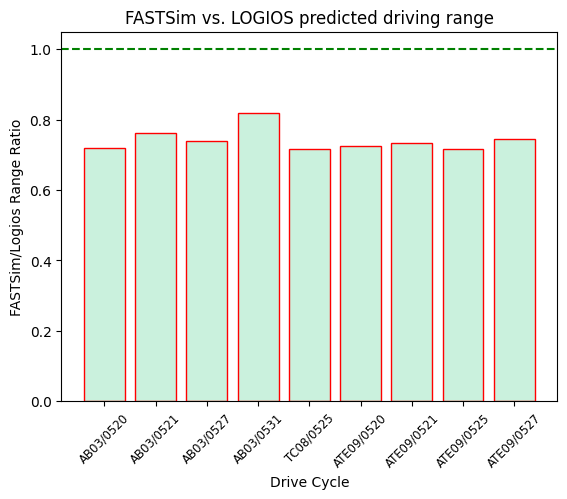

On average, of the 9 simulated drive cycles, FASTSim's simulated range is 74.2% of LOGIOS's


In [6]:
route_days = []
range_diffs = []
for drive_cycle in results.keys():
    route_days.append(drive_cycle)
    fastsim_range = results[drive_cycle]['fastsim_range']
    logios_range = results[drive_cycle]['logios_range']
    range_diffs.append(fastsim_range/logios_range)

plt.bar(route_days, height=range_diffs, edgecolor='red', color='#CAF1DD')
plt.title('FASTSim vs. LOGIOS predicted driving range')
plt.axhline(1.0, color='green', linestyle='dashed')
plt.xlabel('Drive Cycle')
plt.ylabel('FASTSim/Logios Range Ratio')
plt.xticks(rotation=45, fontsize='small')
plt.show()

print(f'On average, of the {len(route_days)} simulated drive cycles, FASTSim\'s simulated range is {np.average(range_diffs)*100:.01f}% of LOGIOS\'s')

# Visualizing FASTSim results summary for all routes

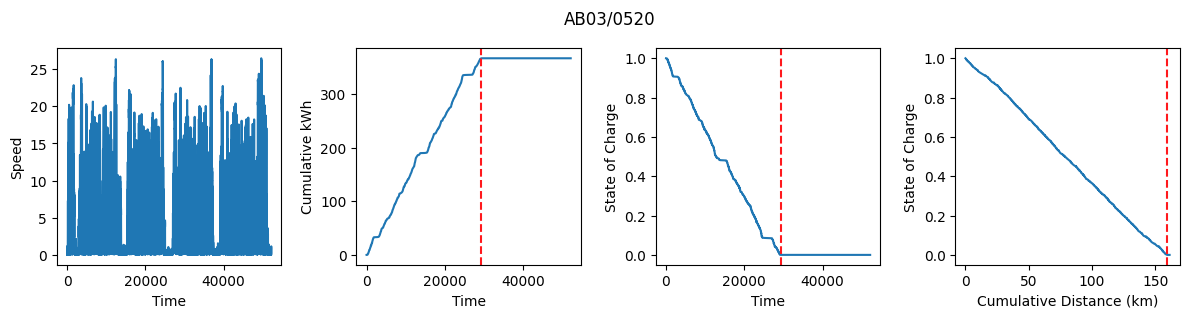

AB03/0520 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 100.29 miles. 161.41 km
  Total time driven (ignoring battery death): 14.49 hours
  Total energy required: 366.50 kWh


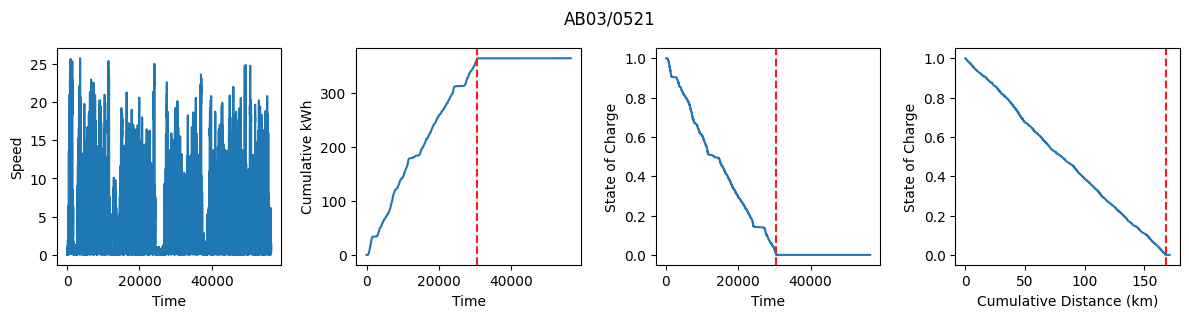

AB03/0521 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 106.33 miles. 171.12 km
  Total time driven (ignoring battery death): 15.69 hours
  Total energy required: 363.72 kWh


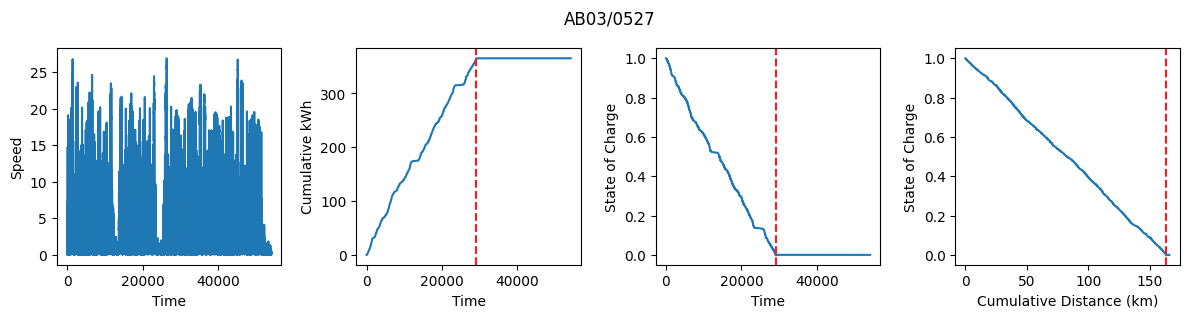

AB03/0527 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 103.36 miles. 166.35 km
  Total time driven (ignoring battery death): 15.04 hours
  Total energy required: 365.30 kWh


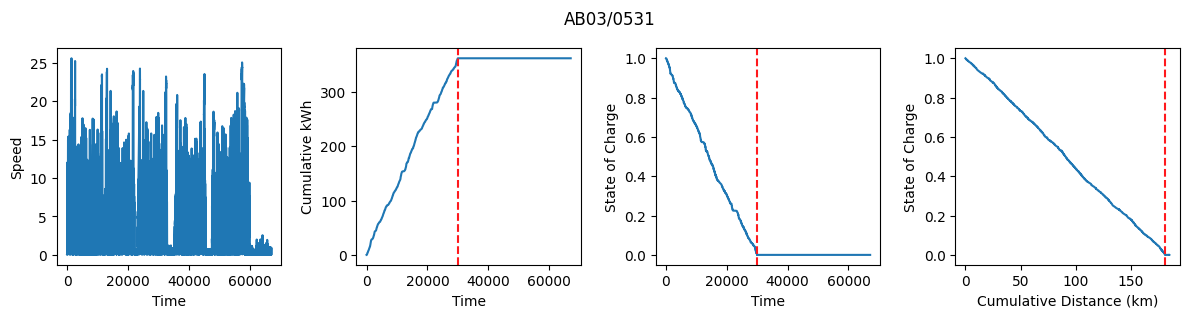

AB03/0531 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 115.03 miles. 185.12 km
  Total time driven (ignoring battery death): 18.65 hours
  Total energy required: 361.50 kWh


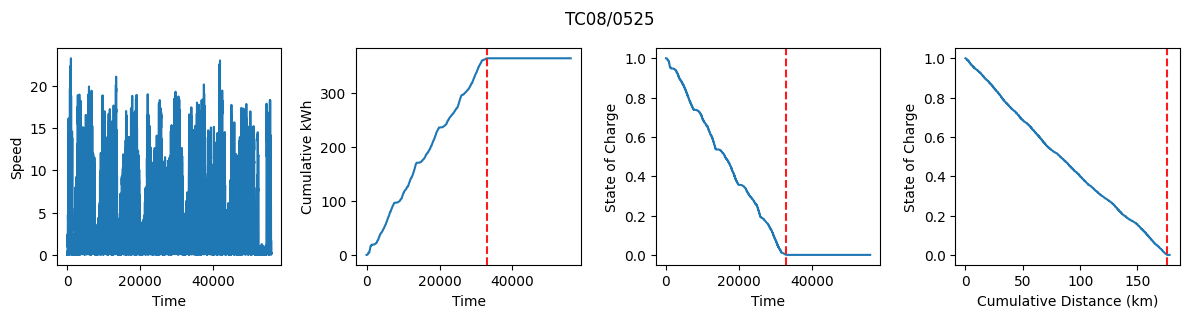

TC08/0525 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 110.62 miles. 178.03 km
  Total time driven (ignoring battery death): 15.55 hours
  Total energy required: 365.31 kWh


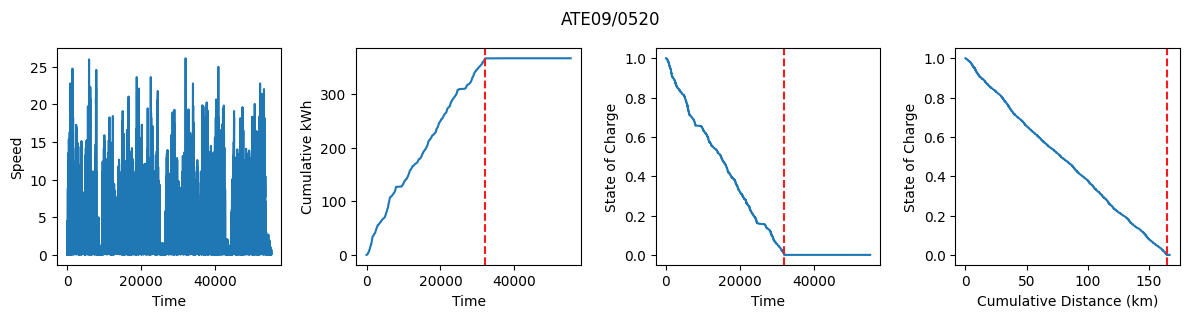

ATE09/0520 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 103.65 miles. 166.81 km
  Total time driven (ignoring battery death): 15.34 hours
  Total energy required: 366.33 kWh


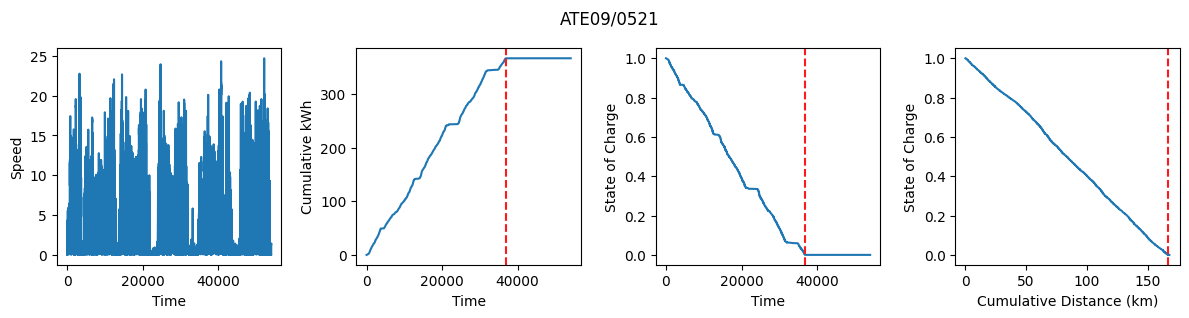

ATE09/0521 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 104.49 miles. 168.16 km
  Total time driven (ignoring battery death): 15.02 hours
  Total energy required: 366.23 kWh


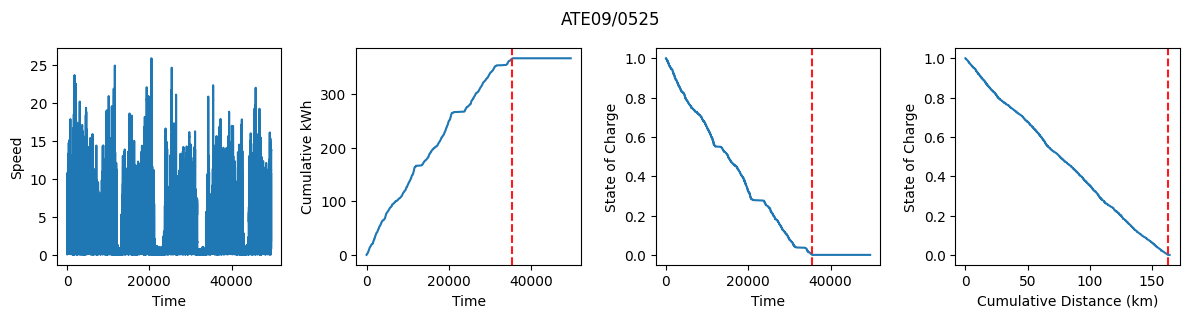

ATE09/0525 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 102.08 miles. 164.29 km
  Total time driven (ignoring battery death): 13.79 hours
  Total energy required: 366.76 kWh


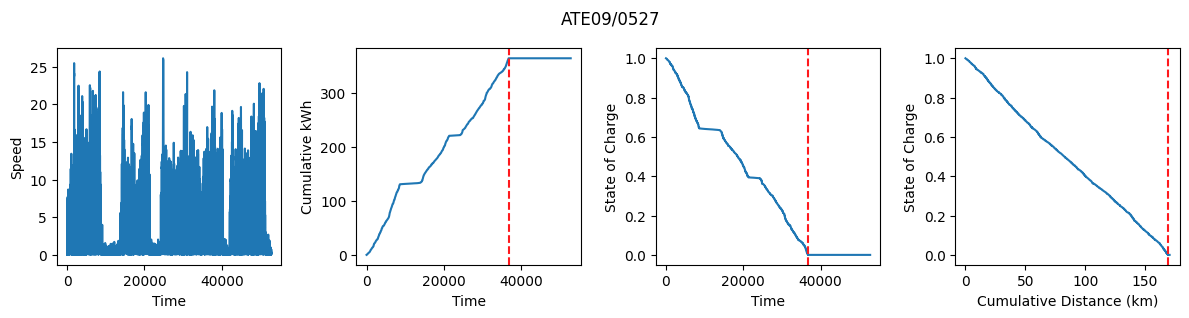

ATE09/0527 Simulation summary:
  Final S.O.C.: 0.00 %
  Distance driven: 105.96 miles. 170.53 km
  Total time driven (ignoring battery death): 14.67 hours
  Total energy required: 364.48 kWh


In [34]:
for route_name, fastsim_output in results.items():
    fastsim_range = fastsim_output['fastsim_range']
    minSoc_time = fastsim_output['minSoc_time']
    df = pd.DataFrame.from_dict(fastsim_output)

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
    fig.tight_layout(h_pad=2, w_pad=2)
    fig.suptitle(f'{route_name}')
    plt.subplots_adjust(top=0.85)
    axs[0].plot(df['time'],df['speed'])
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Speed')
    
    axs[1].plot(df['time'], df['cumKwh'])
    axs[1].axvline(minSoc_time, color='#FF191D', linestyle='dashed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Cumulative kWh')

    axs[2].plot(df['time'],df['soc'])
    axs[2].axvline(minSoc_time, color='#FF191D', linestyle='dashed')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('State of Charge')

    axs[3].plot(df['cumDistKm'],df['soc'])
    axs[3].axvline(fastsim_range, color='#FF191D', linestyle='dashed')
    axs[3].set_xlabel('Cumulative Distance (km)')
    axs[3].set_ylabel('State of Charge')

    plt.show()
    
    print(f'{route_name} Simulation summary:')
    print(f'  Final S.O.C.: {fastsim_output["final_soc"]*100:.2f} %')
    print(f'  Distance driven: {fastsim_output["distance_mi"]:.2f} miles. {fastsim_output["distance_mi"]*utils.km_per_mile:.2f} km')
    print(f'  Total time driven (ignoring battery death): {df["time"].iloc[-1] * 1/3600:.2f} hours')
    print(f'  Total energy required: {df["cumKwh"].iloc[minSoc_time]:.2f} kWh')
    # TODO: How can the cumulative kwh exceed the max capacity of the battery? Simulation roundoff errors or real inconsistency

# Exploring LOGIOS' Discriminated Consumption vs Energy Available Graphs
Exploring the relationship between 'discriminated consumption' and 'energy available' graphs for each route in LOGIOS' "Deliverable 4 Energy Consumption Projection" report.

For each route, Logios' *Deliverable 4 - Energy Consumption Projection* report shows 2 graphs:
1. *Discriminated Consumption*. e.g. Fig 2 for route AB03. These dipict the power consumption over time, broken down into baseline consumption, 60% passenger load consumption, and 6kW average HVAC consumption.
1. *Energy Available Profile*. e.g. Fig 4 for route AB03. These are labeled as depicting the profile for assuming Bus type 1 (overnight charging), 60% passenger occupancy, and 6kW of HVAC load. 

Because our FASTSim simulation was predicting a shorter driving range than LOGIOS' simulation's predictions, we wondered if their Energy Available graphs were *truly* depicting the range of a bus under that full load, or if it was depicting something else (e.g. range of a bus under only baseload).

The graphs below investigate that question:

## AB03: Discriminated Consumption (Fig. 2) vs Energy Available (Fig. 4)

The black line shows exactly what the fig 4 Energy Available graph shows in LOGIOS's report. The blue, orange, and grey 'whisker' lines at each segment show what the energy available graph slope should be accordding to LOGIOS' fig 2 discriminated energy consumption rates. Here we see the black line most closely matches energy consumption of a bus with baseline + 60% occupancy __but NO HVAC load__, contrary to how it is labeled in the report.

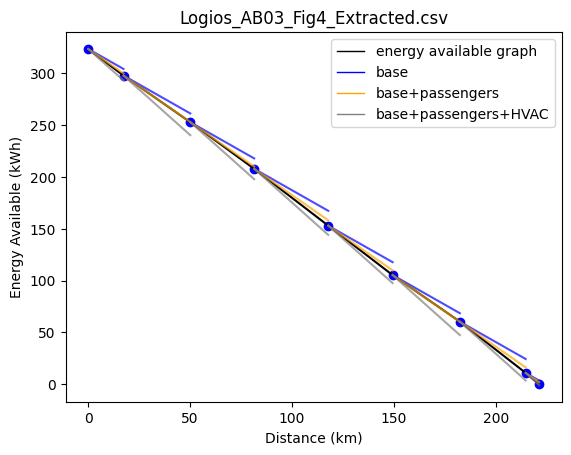

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   0.0 km.  dist: 17.3 km.  energy: -25.7 kWh
[Segment 2] start:  17.3 km.  dist: 32.8 km.  energy: -45.0 kWh
[Segment 3] start:  50.1 km.  dist: 31.3 km.  energy: -45.0 kWh
[Segment 4] start:  81.4 km.  dist: 36.3 km.  energy: -54.9 kWh
[Segment 5] start: 117.7 km.  dist: 31.6 km.  energy: -47.7 kWh
[Segment 6] start: 149.3 km.  dist: 33.0 km.  energy: -45.0 kWh
[Segment 7] start: 182.3 km.  dist: 32.3 km.  energy: -49.5 kWh
[Segment 8] start: 214.6 km.  dist: 6.6 km.  energy: -10.8 kWh


In [42]:
from matplotlib.lines import Line2D

# Given an inital point x0,y0, line slope m, second x value x1, compute y1.
def y(x, m, x0, y0):
    return m*(x-x0) + y0

def compare_logios_graphs_for_route(disc_consump_file, energy_avail_file):
    DISC_CONSUMPT_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Discriminated Consumption'
    df = pd.read_csv(Path(DISC_CONSUMPT_DIR) / disc_consump_file)
    # The energy consumption slopes (kWh/km) of the 3 discriminated consumptions rates
    # Baseline
    base_m = -df.y[0] / df.x[0]
    # Baseline + Passengers
    base_pass_m = -df.y[1] / df.x[1]
    # Baseline + Passengers + HVAC
    base_pass_hvac_m = -df.y[2] / df.x[2]

    # Graph the Energy Available graph (e.g. fig 4)
    ENERGY_AVAILABLE_DIR = '../Data/LOGIOS Data/Report 4 Extracts/Energy Available'
    df = pd.read_csv(Path(ENERGY_AVAILABLE_DIR) / energy_avail_file)
    plt.plot(df.x, df.y, color='black')
    plt.scatter(df.x, df.y, color='blue')

    # Overlay discriminated consumption rates
    # For each segment, show what the energy burn-down would be at the rates depicted in the
    # respective discriminated consumption graph (e.g. fig 2)
    for i in range(len(df)-1):
        # Base
        x0, y0 = df.x[i], df.y[i]
        x1 = df.x[i+1]
        plt.plot([x0, x1], [y0, y(x1, base_m, x0, y0)], color='blue', alpha=0.7, label='baseline')
        plt.plot([x0, x1], [y0, y(x1, base_pass_m, x0, y0)], color='orange', alpha=0.7)
        plt.plot([x0, x1], [y0, y(x1, base_pass_hvac_m, x0, y0)], color='gray', alpha=0.7)

    plt.title(f'{energy_avail_file}')
    plt.xlabel(f'Distance (km)')
    plt.ylabel(f'Energy Available (kWh)')
    custom_lines = [
        Line2D([0], [0], color='black', lw=1),
        Line2D([0], [0], color='blue', lw=1),
        Line2D([0], [0], color='orange', lw=1),
        Line2D([0], [0], color='gray', lw=1),
    ]
    plt.legend(custom_lines, ['energy available graph', 'base', 'base+passengers', 'base+passengers+HVAC'])
    plt.show()

    print(f'Energy-Available Graph consumption rates per segment:')
    for i in range(1, len(df)):
        # Distance Travelled
        dx = df.x[i] - df.x[i-1]
        # Energy consumed
        de = df.y[i] - df.y[i-1]
        print(f"[Segment {i}] start: {df.x[i-1]:5.01f} km.  dist: {dx:3.01f} km.  energy: {de:5.01f} kWh")
        
disc_consump_file = 'Logios_AB03_Fig2_Extracted.csv'
energy_avail_file = 'Logios_AB03_Fig4_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## TC08: Discriminated Consumption (Fig. 11) vs Energy Available (Fig. 13)

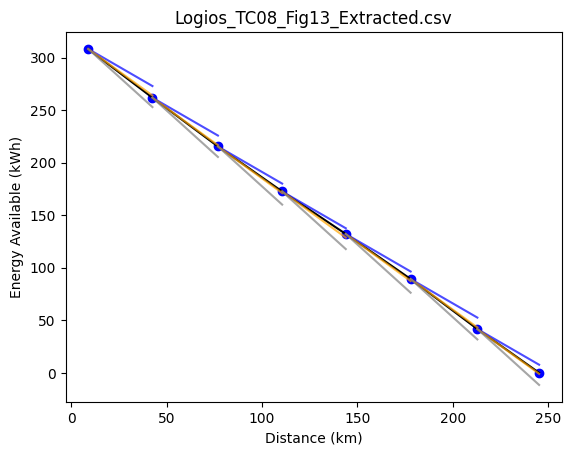

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   8.8 km.  dist: 33.7 km.  energy: -46.4 kWh
[Segment 2] start:  42.5 km.  dist: 34.3 km.  energy: -46.4 kWh
[Segment 3] start:  76.9 km.  dist: 33.7 km.  energy: -42.9 kWh
[Segment 4] start: 110.6 km.  dist: 33.4 km.  energy: -40.5 kWh
[Segment 5] start: 143.9 km.  dist: 34.0 km.  energy: -42.9 kWh
[Segment 6] start: 177.9 km.  dist: 35.0 km.  energy: -47.6 kWh
[Segment 7] start: 212.9 km.  dist: 32.4 km.  energy: -41.7 kWh


In [36]:
disc_consump_file = 'Logios_TC08_Fig11_Extracted.csv'
energy_avail_file = 'Logios_TC08_Fig13_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## TME04: Discriminated Consumption (Fig. 8) vs Energy Available (Fig. 10)

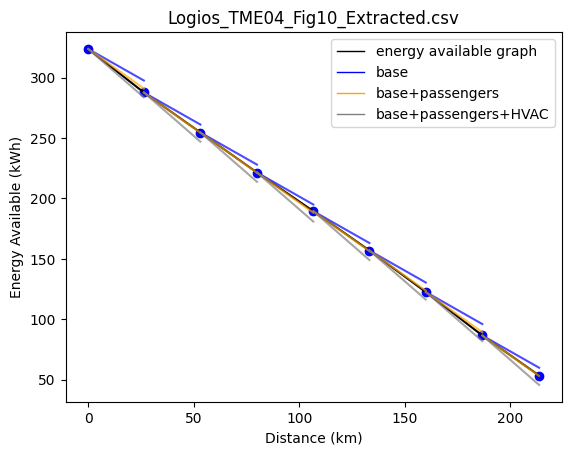

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   0.0 km.  dist: 26.4 km.  energy: -36.0 kWh
[Segment 2] start:  26.4 km.  dist: 26.8 km.  energy: -33.1 kWh
[Segment 3] start:  53.2 km.  dist: 26.8 km.  energy: -33.1 kWh
[Segment 4] start:  80.0 km.  dist: 26.7 km.  energy: -32.0 kWh
[Segment 5] start: 106.7 km.  dist: 26.6 km.  energy: -32.6 kWh
[Segment 6] start: 133.3 km.  dist: 26.7 km.  energy: -34.3 kWh
[Segment 7] start: 159.9 km.  dist: 26.8 km.  energy: -36.1 kWh
[Segment 8] start: 186.8 km.  dist: 26.9 km.  energy: -33.1 kWh


In [43]:
disc_consump_file = 'Logios_TME04_Fig8_Extracted.csv'
energy_avail_file = 'Logios_TME04_Fig10_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

## ATE09: Discriminated Consumption (Fig. 5) vs Energy Available (Fig. 7)

Note: Unlike the other routes, for ATE09 the discriminated consumption graph is presented as the whole day's data (instead of one segment). So the extracted energy burndown rates represent an average over the whole day, instead of the rate of one sampled segment as in the other routes.

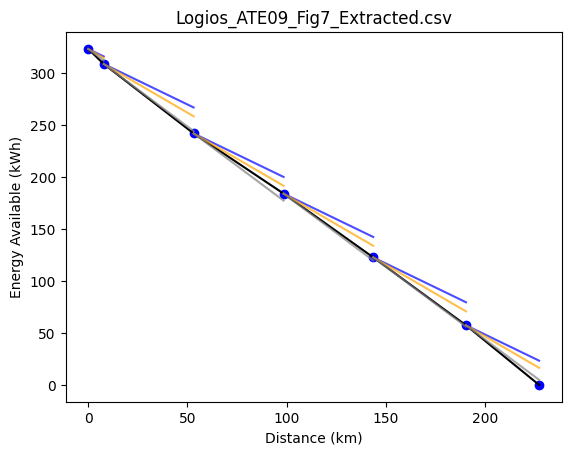

Energy-Available Graph consumption rates per segment:
[Segment 1] start:   0.0 km.  dist: 7.8 km.  energy: -14.5 kWh
[Segment 2] start:   7.8 km.  dist: 45.3 km.  energy: -66.9 kWh
[Segment 3] start:  53.1 km.  dist: 45.3 km.  energy: -57.9 kWh
[Segment 4] start:  98.4 km.  dist: 45.2 km.  energy: -61.4 kWh
[Segment 5] start: 143.6 km.  dist: 46.7 km.  energy: -65.4 kWh
[Segment 6] start: 190.3 km.  dist: 36.8 km.  energy: -57.4 kWh


In [37]:
disc_consump_file = 'Logios_ATE09_Fig5_Extracted.csv'
energy_avail_file = 'Logios_ATE09_Fig7_Extracted.csv'
compare_logios_graphs_for_route(disc_consump_file, energy_avail_file)

These comparisons of graphs appears to show that Logios mislabeled their 'Energy Available' graphs (Figures 4, 10, and 13). 

- For AB03, TC08, and TME04: Though they label them as illustrating the energy consumption with passengers and HVAC, it looks more like they do not include the HVAC consumption. 
- For ATE09: It looks like Fig 7 actually DOES show what it is labeled as, the energy burndown rate assuming base, passengers, and HVAC load. 

# [WIP] Detecting periods when the bus is stopped

As part of our search for why our FASTSim simulation consistently predicts driving ranges that are less than what LOGIOS' simulation predicted, we wondered about periods of the drive cycle when the bus is stopped or idling. 

Does LOGIOS treat stops optimistically (i.e. the stopped bus uses no energy) while FASTSim has a stricter simulation (the bus continues to use some amount of energy even while stopped)?

To investigate this question we want to:
1. Detect periods of the LOGIOS drive cycles where the bus is stopped
2. Strip those periods out of the drive cycle.
3. Run these modified drive cycles through FASTSim to see how the energy consumption and driving range are affected, and how they compare to LOGIOS' simulation results.

The current state of this investigation is just at step 1 - I wrote some naive stop detection logic, that doesn't work very well. It suffers from a lot of fragmentation due to noise in the drive cycle data:

In [8]:
def detect_stops(df, time_range, epsilon = 1*10**-1):
    '''
    Return a list of (start, stop) tuples, each describing a start and stop time (inclusive) of an 
    extent of time when the vehicle was stopped.
    '''
    # Linear search, find contiguous segments of near-zero speed
    extents = []
    stopped = False
    curr_extent = [np.nan, np.nan]
    for i in time_range:
        speed = df.iloc[i]['speed']
        #print('speed', speed)
        if abs(speed) <= epsilon: # We are stopped at this time step
            if not stopped:
                #print(f'Starting extent. t:{i}, speed:{speed}')
                stopped = True
                curr_extent = [i,i]
            else:
                curr_extent[1] = i
        else: # We are moving at this timestep
            if not stopped:
                pass
            else:
                #print(f'Stopping extent. t:{i}, speed:{speed}')
                extents.append(tuple(curr_extent))
                curr_extent = [np.nan, np.nan]
                stopped = False
                
    # Filter out noise: Remove any extents of length less than 15 seconds
    extents = list(filter(lambda x: x[1]-x[0] >= 15, extents))
    # print('extents', extents)
    # print('lengths', list(map(lambda x: x[1]-x[0], extents)))
    return extents

# TODO: Try another approach

data = {
    "speed": [1,2,3,0,0,0,4,5,6],
}
df = pd.DataFrame(data)
time_range = range(0,9)
extents = detect_stops(df, time_range)

## [WIP] Visualizing extent detection for drive cycle AB03/0520

Sections when stop periods are detected are colored in red on the X-axis:

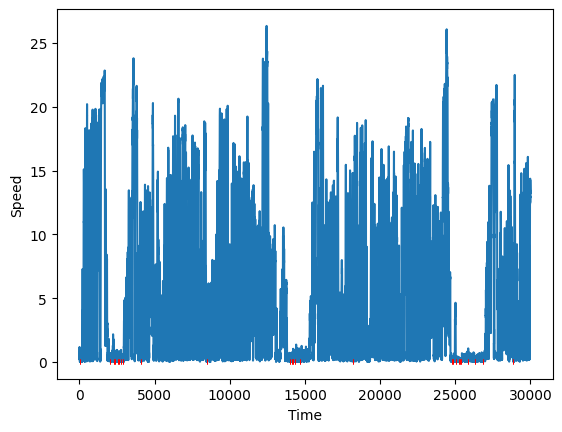

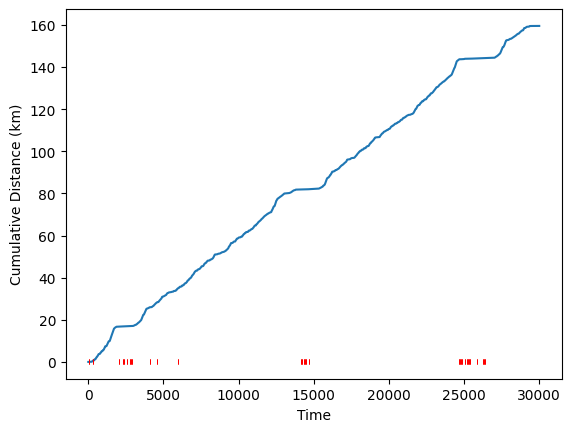

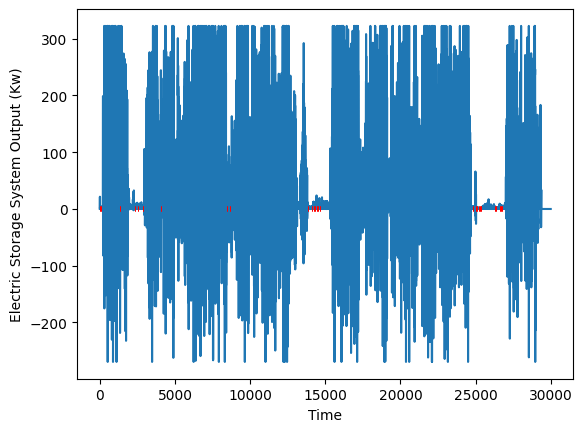

In [9]:
output = results['AB03/0520']
df = pd.DataFrame.from_dict(output)
time_range = range(0,30000)
df = df[time_range.start:time_range.stop]

extents = detect_stops(df, time_range, epsilon=0.3)

plt.plot(df['time'],df['speed'])
plt.xlabel('Time')
plt.ylabel('Speed')
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.show()

plt.plot(df['time'],df['cumDistKm'])
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.xlabel('Time')
plt.ylabel('Cumulative Distance (km)')
plt.show()

plt.plot(df['time'], df['essKwOutAch'])
for extent in extents:
    plt.hlines(0, extent[0], extent[1], color='red', linewidths=4)
plt.xlabel('Time')
plt.ylabel('Electric Storage System Output (Kw)')
plt.show()       